Data: https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data

In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
import pandas as pd
from time import time
import pickle as pkl
from keras.callbacks import EarlyStopping
import math


# Standard libraries
import os
import math
from time import time
from pprint import pprint
from typing import Dict, Any, Tuple

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine learning
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific computing
from scipy.fft import fft, ifft

# File I/O
import pickle as pkl
import shutil

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from time import time
import pandas as pd
from matplotlib import pyplot as plt
# from ucimlrepo import fetch_ucirepo
from sklearn import preprocessing
import pickle as pkl
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
import shutil
os.environ['KAGGLE_CONFIG_DIR'] = 'drive/MyDrive/Kaggle'
!kaggle datasets download -d pateljay731/panama-electricity-load-forecasting
!unzip -q panama-electricity-load-forecasting.zip -d data
!rm panama-electricity-load-forecasting.zip

Dataset URL: https://www.kaggle.com/datasets/pateljay731/panama-electricity-load-forecasting
License(s): unknown
  0% 0.00/2.98M [00:00<?, ?B/s]
100% 2.98M/2.98M [00:00<00:00, 90.5MB/s]


In [ ]:
# Read the train data
df = pd.read_csv("data/train.csv",
                 parse_dates=["datetime"],
                 index_col=["datetime"])

In [ ]:
# Feature selection
newDf = df[[c for c in df if c not in ['nat_demand']] + ['nat_demand']]
col = ['Holiday_ID','holiday', 'school']
newDf = newDf.drop(columns=col)

# Keep columns with higher absolute correlation of 50%
corr_matrix = newDf.corr()
high_corr_cols = corr_matrix[abs(corr_matrix['nat_demand']) > 0.5].index
data = newDf[high_corr_cols].copy()

# Scale data using MinMaxScaling
xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
newDf[[c for c in newDf if c not in ['nat_demand']]] = xScaler.fit_transform(newDf[[c for c in newDf if c not in ['nat_demand']]])
newDf[["nat_demand"]] = yScaler.fit_transform(newDf[["nat_demand"]])
newDfArray = newDf.to_numpy()

In [ ]:
class TimeLimitCallback(Callback):
    """
    Callback to stop training after a specified time limit.

    Attributes:
        start_time (float): The time when training begins.
        time_limit (float): The maximum allowed training time in seconds.
    """
    def __init__(self, time_limit: float):
        super(TimeLimitCallback, self).__init__()
        self.start_time: float = 0
        self.time_limit: float = time_limit

    def on_train_begin(self, logs: Dict[str, Any] = None) -> None:
        """Set the start time when training begins."""
        self.start_time = time()

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None) -> None:
        """Check if time limit is exceeded and stop training if so."""
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")

class LossThresholdCallback(Callback):
    """
    Callback to stop training when a specified loss threshold is reached.

    Attributes:
        threshold (float): The loss threshold at which to stop training.
    """
    def __init__(self, threshold: float):
        super(LossThresholdCallback, self).__init__()
        self.threshold: float = threshold

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None) -> None:
        """Check if loss threshold is reached and stop training if so."""
        logs = logs or {}
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss is not None and loss <= self.threshold:
            print(f"\nReached training loss of {self.threshold}, stopping training.")
            self.model.stop_training = True
        elif val_loss is not None and val_loss <= self.threshold:
            print(f"\nReached validation loss of {self.threshold}, stopping training.")
            self.model.stop_training = True

def series_to_window_series(time_series: np.ndarray, window_size: int) -> np.ndarray:
    """
    Convert a time series to a windowed series.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.

    Returns:
        np.ndarray: The windowed time series.
    """
    rows, cols = time_series.shape
    num_windows = rows - window_size + 1
    windows = np.lib.stride_tricks.sliding_window_view(time_series, (window_size, 1))
    return windows.reshape(num_windows, cols, window_size)

def window_series_to_series(window_series: np.ndarray) -> np.ndarray:
    """
    Convert a windowed series back to a regular time series.

    Args:
        window_series (np.ndarray): The windowed time series.

    Returns:
        np.ndarray: The reconstructed time series.
    """
    if window_series.ndim == 2:
        tmp_shape = window_series.shape
        window_series = window_series.reshape((tmp_shape[0], 1, tmp_shape[1]))

    num_windows, cols, window_size = window_series.shape
    original_length = num_windows + window_size - 1
    result = np.zeros((original_length, cols))

    indices = np.arange(window_size)[:, None] + np.arange(num_windows)
    np.add.at(result, indices, window_series.transpose((2, 0, 1)))

    counts = np.zeros((original_length, cols))
    np.add.at(counts, indices, 1)
    result /= counts

    return np.asarray(result, dtype=window_series.dtype)

def time_series_to_frequencies(time_series: np.ndarray, sampling_frequency: float = 1,
                               mask_percent: float = 0, mask_lower: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a time series to frequency domain.

    Args:
        time_series (np.ndarray): The input time series.
        sampling_frequency (float): The sampling frequency of the time series.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Frequencies and their intensities.
    """
    intensities = fft(time_series)
    frequencies = np.fft.fftfreq(len(intensities), 1/sampling_frequency)

    if mask_percent > 0:
        mask_index = int(len(frequencies) * (mask_percent if mask_lower else 1 - mask_percent))
        frequencies = frequencies[mask_index:] if mask_lower else frequencies[:mask_index]

    return frequencies, intensities

def frequencies_to_time_series(frequencies: np.ndarray, complex_array_shape: Tuple[int, ...],
                               mask_percent: float = 0, mask_lower: bool = False) -> np.ndarray:
    """
    Convert frequency domain back to time series.

    Args:
        frequencies (np.ndarray): The input frequencies.
        complex_array_shape (Tuple[int, ...]): The shape of the complex array.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        np.ndarray: The reconstructed time series.
    """
    if not np.iscomplex(frequencies).any():
        frequencies = unflatten_complex_array(frequencies, complex_array_shape)
    time_series = ifft(frequencies).real
    return time_series

def flatten_complex_array(complex_array: np.ndarray) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Flatten a complex array into a real array.

    Args:
        complex_array (np.ndarray): The input complex array.

    Returns:
        Tuple[np.ndarray, Tuple[int, ...]]: Flattened array and original shape.
    """
    complex_array_shape = complex_array.shape
    real, imag = complex_array.real, complex_array.imag
    flattened_array = np.concatenate((real, imag))
    return flattened_array, complex_array_shape

def unflatten_complex_array(flattened_array: np.ndarray, complex_array_shape: Tuple[int, ...]) -> np.ndarray:
    """
    Unflatten a real array back into a complex array.

    Args:
        flattened_array (np.ndarray): The flattened real array.
        complex_array_shape (Tuple[int, ...]): The shape of the original complex array.

    Returns:
        np.ndarray: The reconstructed complex array.
    """
    complex_array_length = len(flattened_array) // 2
    real = flattened_array[:complex_array_length]
    imag = flattened_array[complex_array_length:]
    complex_array = np.empty(complex_array_shape, dtype=np.complex128)
    complex_array.real = real
    complex_array.imag = imag
    return complex_array

def sliding_window_time_series_to_sliding_window_frequencies(sliding_window_time_series: np.ndarray,
                                                             sampling_frequency: float = 1,
                                                             flatten_complex: bool = True,
                                                             mask_percent: float = 0,
                                                             mask_lower: bool = True) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Convert a sliding window time series to sliding window frequencies.

    Args:
        sliding_window_time_series (np.ndarray): The input sliding window time series.
        sampling_frequency (float): The sampling frequency of the time series.
        flatten_complex (bool): Whether to flatten the complex array.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        Tuple[np.ndarray, Tuple[int, ...]]: Sliding window frequencies and complex array shape.
    """
    sliding_window_frequencies = []
    num_sliding_windows, num_features, _ = sliding_window_time_series.shape
    complex_array_shape = None

    for sliding_window_index in range(num_sliding_windows):
        feature_sliding_window = []
        for feature_index in range(num_features):
            _, frequencies = time_series_to_frequencies(sliding_window_time_series[sliding_window_index, feature_index, :],
                                                        sampling_frequency, mask_percent, mask_lower)
            if flatten_complex:
                frequencies, complex_array_shape = flatten_complex_array(frequencies)
            feature_sliding_window.append(frequencies)
        sliding_window_frequencies.append(feature_sliding_window)

    return np.array(sliding_window_frequencies), complex_array_shape

def sliding_window_frequencies_to_sliding_window_time_series(sliding_window_frequencies: np.ndarray,
                                                             complex_array_shape: Tuple[int, ...]) -> np.ndarray:
    """
    Convert sliding window frequencies back to sliding window time series.

    Args:
        sliding_window_frequencies (np.ndarray): The input sliding window frequencies.
        complex_array_shape (Tuple[int, ...]): The shape of the complex array.

    Returns:
        np.ndarray: The reconstructed sliding window time series.
    """
    if sliding_window_frequencies.ndim == 2:
        tmp_shape = sliding_window_frequencies.shape
        sliding_window_frequencies = sliding_window_frequencies.reshape((tmp_shape[0], 1, tmp_shape[1]))

    sliding_window_time_series = np.apply_along_axis(lambda x: frequencies_to_time_series(x, complex_array_shape),
                                                     axis=2, arr=sliding_window_frequencies)
    return sliding_window_time_series

def plot_expected_predicted_data(expected_series: np.ndarray, predicted_series: np.ndarray,
                                 image_path: str = None, title: str = "Expected vs Predicted") -> None:
    """
    Plot expected and predicted data.

    Args:
        expected_series (np.ndarray): The expected time series.
        predicted_series (np.ndarray): The predicted time series.
        image_path (str, optional): Path to save the plot image.
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(20, 6))
    plot_expected = expected_series[1:]
    plot_predicted = predicted_series[1:]
    ax.plot(plot_expected, label='Expected')
    ax.plot(plot_predicted, label='Predicted')
    ax.set_title(title)
    ax.legend()
    plt.show()

def evaluate(expected: np.ndarray, predicted: np.ndarray) -> Dict[str, float]:
    """
    Evaluate model performance using various metrics.

    Args:
        expected (np.ndarray): The expected values.
        predicted (np.ndarray): The predicted values.

    Returns:
        Dict[str, float]: A dictionary of evaluation metrics.
    """
    mse = mean_squared_error(expected, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(expected, predicted)
    r2 = r2_score(expected, predicted)
    mape = np.mean(np.abs((expected - predicted) / expected)) * 100
    explained_var = explained_variance_score(expected, predicted)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_var
    }

def prepare_lstm_training_data(time_series: np.ndarray, window_size: int, forecast_horizon: int,
                               test_ratio: float, val_ratio: float, frequency: bool = False) -> Tuple[np.ndarray, ...]:
    """
    Prepare data for LSTM model training.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.
        forecast_horizon (int): The number of future time steps to predict.
        test_ratio (float): The ratio of data to use for testing.
        val_ratio (float): The ratio of training data to use for validation.
        frequency (bool): Whether to use frequency domain data.

    Returns:
        Tuple[np.ndarray, ...]: Training, validation, and test data splits.
    """
    features = time_series
    target = time_series[:, -1].reshape(-1, 1)

    X = series_to_window_series(features, window_size)
    y = series_to_window_series(target, forecast_horizon)

    X = X[:-forecast_horizon]
    y = y[window_size:]

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )

    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, shuffle=False
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

def prepare_fdn_training_data(time_series: np.ndarray, window_size: int, forecast_horizon: int,
                              test_ratio: float, val_ratio: float, frequency: bool = False,
                              mask_percent: float = 0, mask_lower: bool = True,
                              use_pca: bool = False, pca_var_exp_ratio: float = 0.95) -> Tuple[Tuple[np.ndarray, ...], Tuple[np.ndarray, ...], Tuple[int, ...]]:
    """
    Prepare data for FDN model training.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.
        forecast_horizon (int): The number of future time steps to predict.
        test_ratio (float): The ratio of data to use for testing.
        val_ratio (float): The ratio of training data to use for validation.
        frequency (bool): Whether to use frequency domain data.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.
        use_pca (bool): Whether to use PCA for dimensionality reduction.
        pca_var_exp_ratio (float): The desired explained variance ratio for PCA.

    Returns:
        Tuple[Tuple[np.ndarray, ...], Tuple[np.ndarray, ...], Tuple[int, ...]]:
        Time series data splits, frequency data splits, and target complex array shape.
    """

    features = time_series[:, :-1]
    target = time_series[:, -1].reshape(-1, 1)

    X = series_to_window_series(features, window_size)
    y = series_to_window_series(target, forecast_horizon)

    X = X[:-forecast_horizon]
    y = y[window_size:]

    X_freq, _ = sliding_window_time_series_to_sliding_window_frequencies(X)
    y_freq, target_complex_array_shape = sliding_window_time_series_to_sliding_window_frequencies(y)

    X_freq = X_freq.reshape((X_freq.shape[0], X_freq.shape[1] * X_freq.shape[2]))
    y_freq = y_freq.reshape((y_freq.shape[0], y_freq.shape[1] * y_freq.shape[2]))

    X_freq_train_val, X_freq_test, y_freq_train_val, y_freq_test = train_test_split(
        X_freq, y_freq, test_size=test_ratio, shuffle=False
    )

    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_freq_train, X_freq_val, y_freq_train, y_freq_val = train_test_split(
        X_freq_train_val, y_freq_train_val, test_size=val_size_adjusted, shuffle=False
    )

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, shuffle=False
    )

    time_series_data = (X_train, y_train, X_val, y_val, X_test, y_test)
    frequencies_data = (X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test)

    return time_series_data, frequencies_data, target_complex_array_shape

In [ ]:
def build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, total_trainable_params, max_layer_width, min_layer_width):
    input_shape = (num_input_features, window_size)

    model = Sequential()

    # Add LSTM layer
    # print("LSTM_UNITS_REQUIRED:", total_trainable_params // (4 * (input_shape[1] + 1)))
    lstm_units = min(max_layer_width, total_trainable_params // (4 * (input_shape[1] + 1)))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))

    # Calculate remaining parameters for dense layers
    lstm_params = lstm_units * (4 * (input_shape[1] + lstm_units + 1))
    remaining_params = total_trainable_params - lstm_params

    # Add dense layers
    dense_layers = []
    while remaining_params > 0:
        if len(dense_layers) == 0:
            input_dim = lstm_units
        else:
            input_dim = dense_layers[-1]

        output_dim = min(remaining_params // (input_dim + 1), max_layer_width)
        if output_dim < min_layer_width:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)

    # Add dense layers to the model
    for units in dense_layers[:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=forecast_horizon))

    # Verify total trainable parameters
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")


    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True,)

    # Print summary for debugging
    # model.summary()
    return model

# Usage
# model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000)

In [ ]:
def build_balanced_densenet_model(num_input_features, forecast_horizon, total_trainable_params, max_layer_width, min_layer_width, layer_width_decay=1):
    input_shape = (num_input_features,)

    model = Sequential()

    # Calculate number of layers and units per layer
    remaining_params = total_trainable_params
    dense_layers = []
    input_dim = input_shape[0]

    # Define a decay factor for layer sizes
    decay_factor = layer_width_decay

    while remaining_params > 0:
        if len(dense_layers) == 0:
            output_dim = max_layer_width
        else:
            output_dim = max(int(dense_layers[-1] * decay_factor), min_layer_width)

        output_dim = min(output_dim, remaining_params // (input_dim + 1))

        if output_dim < min_layer_width:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)
        input_dim = output_dim

    # Adjust the last layer to use remaining parameters
    if remaining_params > 0 and len(dense_layers) > 1:
        last_layer_size = dense_layers[-1] + remaining_params // (dense_layers[-2] + 1)
        dense_layers[-1] = min(last_layer_size, max_layer_width)

    # Add dense layers to the model
    model.add(Dense(units=dense_layers[0], activation='relu', input_shape=input_shape))

    for units in dense_layers[1:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=forecast_horizon*2))  # x2 due to real and imag components

    # Verify total trainable parameters
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")

    # Compile model with AdamW optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Print summary for debugging
    # model.summary()
    return model

# model = build_balanced_varying_densenet_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000, max_layer_width=100, min_layer_width=32)

In [ ]:
# def lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10):

def fdn_driver(params):
    time_series_data = params["time_series_data"]
    window_size = params["window_size"]
    forecast_horizon = params["forecast_horizon"]
    test_ratio = params["test_ratio"]
    val_ratio = params["val_ratio"]
    model_size = params["model_size"]
    epochs = params["epochs"]
    train_time = params["train_time"]
    loss_threshold_value = params["loss_threshold_value"]
    verbose = params["verbose"]
    max_layer_width = params["max_layer_width"]
    min_layer_width = params["min_layer_width"]

    initialTime = time()
    time_series_data, frequencies_data, target_complex_array_shape = prepare_fdn_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio)

    X_train, y_train, X_val, y_val, X_test, y_test = time_series_data
    X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test = frequencies_data

    num_input_features = X_freq_train.shape[1]
    model = build_balanced_densenet_model(num_input_features, forecast_horizon, model_size, max_layer_width, min_layer_width)
    if verbose:
        model.summary()

    if verbose:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
    else:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
    loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
    callbacks = [earlyStop, loss_threshold]
    if train_time > 0:
        time_limit_callback = TimeLimitCallback(time_limit=train_time)
        callbacks.append(time_limit_callback)
    if verbose:
        trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks)#, verbose=0)
    else:
        trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks, verbose=0)

    predicted = model.predict(X_freq_test)

    predicted = sliding_window_frequencies_to_sliding_window_time_series(predicted, target_complex_array_shape)

    predicted = window_series_to_series(predicted)
    predicted = yScaler.inverse_transform(predicted)

    expected = window_series_to_series(y_test)
    expected = yScaler.inverse_transform(expected)

    mse = ((expected - predicted)**2).mean()
    totalTime = time() - initialTime
    information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}
    return information




def lstm_driver(params):
    time_series_data = params["time_series_data"]
    window_size = params["window_size"]
    forecast_horizon = params["forecast_horizon"]
    test_ratio = params["test_ratio"]
    val_ratio = params["val_ratio"]
    model_size = params["model_size"]
    epochs = params["epochs"]
    train_time = params["train_time"]
    loss_threshold_value = params["loss_threshold_value"]
    verbose = params["verbose"]
    max_layer_width = params["max_layer_width"]
    min_layer_width = params["min_layer_width"]

    initialTime = time()
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio, frequency=False)
    num_input_features = X_train.shape[1]
    model = build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, model_size, max_layer_width, min_layer_width)

    if verbose:
        model.summary()

    if verbose:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
    else:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
    loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
    callbacks = [earlyStop, loss_threshold]
    if train_time > 0:
        time_limit_callback = TimeLimitCallback(time_limit=train_time)
        callbacks.append(time_limit_callback)
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    if not verbose:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)#, verbose=0)
    else:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    predicted = model.predict(X_test)
    predicted = window_series_to_series(predicted)
    predicted = yScaler.inverse_transform(predicted)

    expected = window_series_to_series(y_test)
    expected = yScaler.inverse_transform(expected)

    mse = ((expected - predicted)**2).mean()
    totalTime = time() - initialTime
    information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

In [ ]:
parameters = [
    {
        "time_series_data": newDfArray[:1000000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 10000,
        "epochs": 2000,
        "train_time": 2000,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 20,
        "min_layer_width": 10
    }
]
params = parameters[0]
time_series_data = params["time_series_data"]
window_size = params["window_size"]
forecast_horizon = params["forecast_horizon"]
test_ratio = params["test_ratio"]
val_ratio = params["val_ratio"]
model_size = params["model_size"]
epochs = params["epochs"]
train_time = params["train_time"]
loss_threshold_value = params["loss_threshold_value"]
verbose = params["verbose"]
max_layer_width = params["max_layer_width"]
min_layer_width = params["min_layer_width"]

initialTime = time()
time_series_data, frequencies_data, target_complex_array_shape = prepare_fdn_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio)

X_train, y_train, X_val, y_val, X_test, y_test = time_series_data
X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test = frequencies_data

num_input_features = X_freq_train.shape[1]
model = build_balanced_densenet_model(num_input_features, forecast_horizon, model_size, max_layer_width, min_layer_width)
if verbose:
    model.summary()

if verbose:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
else:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
callbacks = [earlyStop, loss_threshold]
if train_time > 0:
    time_limit_callback = TimeLimitCallback(time_limit=train_time)
    callbacks.append(time_limit_callback)
if verbose:
    trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks)#, verbose=0)
else:
    trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks, verbose=0)

predicted = model.predict(X_freq_test)

predicted = sliding_window_frequencies_to_sliding_window_time_series(predicted, target_complex_array_shape)

predicted = window_series_to_series(predicted)
predicted = yScaler.inverse_transform(predicted)

expected = window_series_to_series(y_test)
expected = yScaler.inverse_transform(expected)

mse = ((expected - predicted)**2).mean()
totalTime = time() - initialTime
information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │           9,373 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 13)                  │             182 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,017 (39.13 KB)

 Trainable params: 10,017 (39.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - loss: 1.8205 - val_loss: 0.1874
Epoch 2/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - loss: 0.1078 - val_loss: 0.0584
Epoch 3/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - loss: 0.0514 - val_loss: 0.0537
Epoch 4/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - loss: 0.0459 - val_loss: 0.0481
Epoch 5/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 72s 75ms/step - loss: 0.0405 - val_loss: 0.0434
Epoch 6/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - loss: 0.0363 - val_loss: 0.0394
Epoch 7/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 79s 75ms/step - loss: 0.0329 - val_loss: 0.0413
Epoch 8/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - loss: 0.0311 - val_loss: 0.0360
Epoch 9/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 74s 77ms/step - loss: 0.0289 - val_loss: 0.0396
Epoch 10/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - loss: 0.0274 - val_loss: 0.0354
Epoch 11/2000
957/957 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - loss: 0.0268 - val_loss: 0.0342
Epoch 12

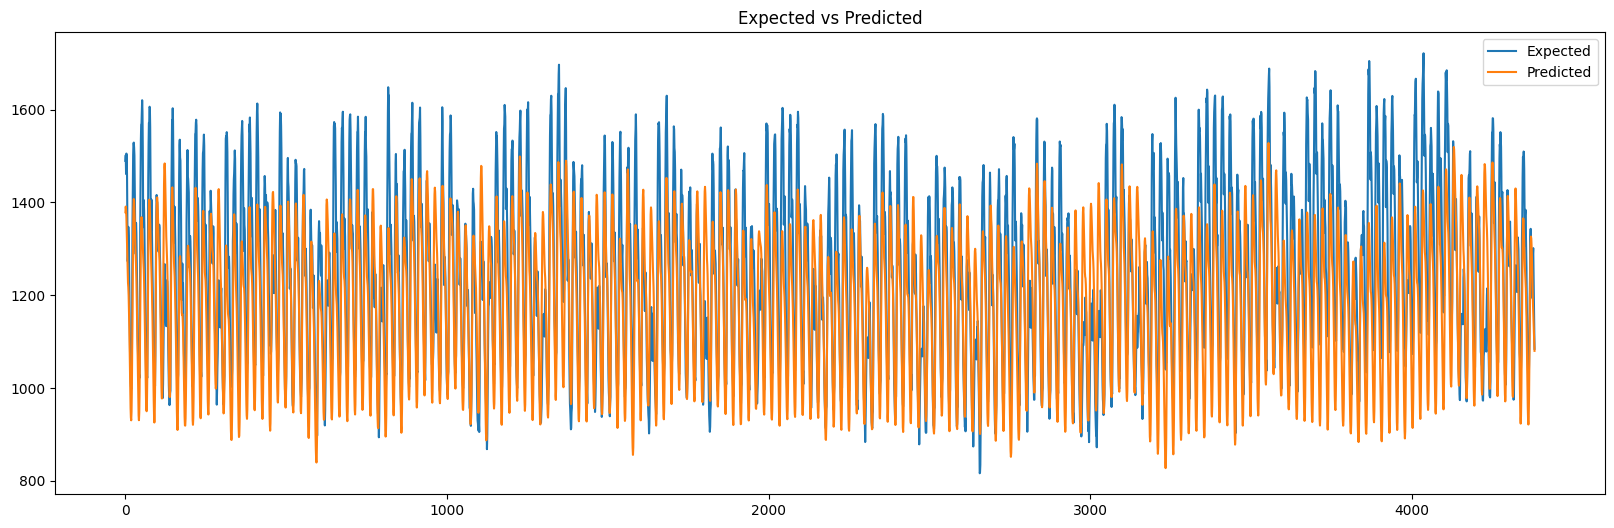

15801.144890658043

In [ ]:
plot_expected_predicted_data(information["expected"], information["predicted"])
information["mse"]

In [ ]:
parameters = [
    {
        "time_series_data": newDfArray[:100000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 10000,
        "epochs": 2000,
        "train_time": 2000,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
]
params = parameters[0]
time_series_data = params["time_series_data"]
window_size = params["window_size"]
forecast_horizon = params["forecast_horizon"]
test_ratio = params["test_ratio"]
val_ratio = params["val_ratio"]
model_size = params["model_size"]
epochs = params["epochs"]
train_time = params["train_time"]
loss_threshold_value = params["loss_threshold_value"]
verbose = params["verbose"]
max_layer_width = params["max_layer_width"]
min_layer_width = params["min_layer_width"]

initialTime = time()
X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio, frequency=False)
num_input_features = X_train.shape[1]
model = build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, model_size, max_layer_width, min_layer_width)

if verbose:
    model.summary()

if verbose:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
else:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
callbacks = [earlyStop, loss_threshold]
if train_time > 0:
    time_limit_callback = TimeLimitCallback(time_limit=train_time)
    callbacks.append(time_limit_callback)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
if not verbose:
    trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)#, verbose=0)
else:
    trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

predicted = model.predict(X_test)
predicted = window_series_to_series(predicted)
predicted = yScaler.inverse_transform(predicted)

expected = window_series_to_series(y_test)
expected = yScaler.inverse_transform(expected)

mse = ((expected - predicted)**2).mean()
totalTime = time() - initialTime
information1 = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

In [ ]:
plot_expected_predicted_data(information1["expected"], information1["predicted"])
information1["mse"]

In [ ]:
# time_series_data = newDfArray[:1000]
# window_size=7
# forecast_horizon=5
# test_ratio=0.1
# val_ratio=0.2
# model_size=8000
# epochs=200
# train_time=300
# loss_threshold_value = 0.01
# verbose=True
# max_layer_width=30
# min_layer_width=10
from pprint import pprint
import pickle as pkl

results_folder = "drive/MyDrive/CS297/Results/FDN/TrainTime"

parameters = [
    {
        "time_series_data": newDfArray[:10000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 25000,
        "epochs": 2000,
        "train_time": x,
        "loss_threshold_value": 0.01,
        "verbose": False,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
    for x in range(50, 1000, 20)
]


for index, param in enumerate(parameters):
    print(f"{index}/{len(parameters)}")
    information = fdn_driver(param)
    with open(f"{results_folder}/train_time_{param['train_time']}.pkl", 'wb') as f:
        pkl.dump(information, f)
    pprint(param)
# information = lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10)

In [ ]:
# time_series_data = newDfArray[:1000]
# window_size=7
# forecast_horizon=5
# test_ratio=0.1
# val_ratio=0.2
# model_size=8000
# epochs=200
# train_time=300
# loss_threshold_value = 0.01
# verbose=True
# max_layer_width=30
# min_layer_width=10
from pprint import pprint
import pickle as pkl

results_folder = "drive/MyDrive/CS297/Results/LSTM/ModelSize"

parameters = [
    {
        "time_series_data": newDfArray[:10000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": x,
        "epochs": 200,
        "train_time": 300,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
    for x in range(45000, 100000, 5000)
]


for param in parameters:
    information = lstm_driver(param)
    with open(f"{results_folder}/model_size_{param['model_size']}.pkl", 'wb') as f:
        pkl.dump(information, f)
    pprint(param)
# information = lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10)

In [ ]:
newDfArraySample = newDfArray[:10000]

In [ ]:
# seriesToRollingWindowSeries
def time_series_to_time_window_series(time_series, window_size):
    """
    Takes a 2D array as input and returns a 3D array
    """

    # Get the shape of the original array
    rows, cols = time_series.shape

    # Calculate the number of windows
    num_windows = rows - window_size + 1

    # Use stride tricks to create a view with overlapping windows
    windows = np.lib.stride_tricks.sliding_window_view(
                time_series, (window_size, cols)
                )

    # Reshape to get the desired 3D array
    return windows.reshape(num_windows, window_size, cols)


def prepare_training_data(
        time_series, window_size, forecast_horizon,
        test_ratio, val_ratio, frequency=False
    ):

    # Separate features and target
    features = time_series#[:, :-1]  # All columns except the last
    target = time_series[:, -1].reshape(-1, 1)     # Last column

    # Use the provided function to create time windows for features
    X = time_series_to_time_window_series(features, window_size)

    # Prepare target values (y)
    y = time_series_to_time_window_series(target, forecast_horizon)

    # Adjust y to align with X and remove extra dimension
    X = X[:-forecast_horizon]
    y = y[window_size:]

    # X, y = prepare_time_series_data(array_2d, window_size, forecast_horizon)

    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
                                                    X, y, test_size=test_ratio,
                                                    shuffle=False
                                                )

    # Second split: separate validation set from training set
    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
                                            X_train_val, y_train_val,
                                            test_size=val_size_adjusted,
                                            shuffle=False
                                        )
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(newDfArraySample, window_size=50, forecast_horizon=5, test_ratio=0.1, val_ratio=0.2, frequency=False)

In [ ]:
model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000)

Building model with target 80000 parameters
Added LSTM layer with 89 units, params: 36668
Added LSTM layer with 66 units, params: 35112
Modified last LSTM layer to have return_sequences=False
Added Dense layer with 33 units, params: 2211
Added Output Dense layer with 5 units, params: 170
Total parameters used: 74161/80000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 89)              │          36,668 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 66)                  │          41,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 33)                  │           2,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,233 (313.41 KB)

 Trainable params: 80,233 (313.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params, single_lstm=False):
    model = Sequential()
    current_params = 0

    # Heuristic to decide number of LSTM layers and units based on the total_trainable_params
    lstm_units = math.isqrt(total_trainable_params // 10)  # Initial units guess
    lstm_layers = 1 if single_lstm else max(2, int(math.log(total_trainable_params, 10) // 1))  # Minimum 2 layers if not single_lstm
    min_units = 32  # Minimum units per layer

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # First LSTM layer with input shape
    input_dim = X_train.shape[2]
    layer_params = calculate_lstm_params(lstm_units, input_dim)
    current_params += layer_params

    if current_params <= total_trainable_params:
        model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2]), return_sequences=False))
        print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    else:
        print("Cannot add any layers without exceeding parameter limit.")
        return model

    # If single_lstm is True, we skip additional LSTM layers and add Dense layers
    if not single_lstm:
        # Add additional LSTM layers and reduce units progressively, checking parameter limit
        for i in range(1, lstm_layers - 1):
            lstm_units = max(min_units, int(lstm_units * 0.75))  # Gradually reduce units
            layer_params = calculate_lstm_params(lstm_units, lstm_units)  # Recurrent input dimension = lstm_units

            if current_params + layer_params <= total_trainable_params:
                model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=(i < lstm_layers - 2)))
                current_params += layer_params
                print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
            else:
                break  # Stop adding more LSTM layers if we exceed the limit

    # Add Dense layers with the remaining parameters
    dense_units = max(min_units, lstm_units // 2)
    while current_params < total_trainable_params:
        layer_params = calculate_dense_params(dense_units, dense_units)
        if current_params + layer_params <= total_trainable_params:
            model.add(Dense(units=dense_units))
            current_params += layer_params
            print(f"Added Dense layer with {dense_units} units, params: {layer_params}")
            dense_units = max(min_units, int(dense_units * 0.75))  # Gradually reduce units
        else:
            break

    # Add Dropout layer
    model.add(Dropout(0.2))  # Dropout layer doesn't add parameters

    # Output layer
    layer_params = calculate_dense_params(dense_units, ForecastHorizon)
    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(ForecastHorizon))
        current_params += layer_params
        print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")
    else:
        print(current_params + layer_params, total_trainable_params)
        print("Cannot add the final output layer without exceeding parameter limit.")

    print(f"Total parameters used: {current_params}/{total_trainable_params}")

    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Print summary for debugging
    model.summary()

    return model

In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params, single_lstm_layer=False):
    model = Sequential()
    current_params = 0

    # Heuristic to decide number of LSTM units based on total_trainable_params
    lstm_units = max(32, math.isqrt(total_trainable_params // 10))  # Ensure at least 32 units
    min_units = 32  # Minimum units per layer

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # First LSTM layer with input shape
    input_dim = X_train.shape[2]
    layer_params = calculate_lstm_params(lstm_units, input_dim)

    if layer_params <= total_trainable_params:
        model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, input_dim),
                       return_sequences=False))
        current_params += layer_params
        print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    else:
        print("Cannot add the LSTM layer without exceeding parameter limit.")
        return model

    if single_lstm_layer:
        # Calculate remaining parameters
        remaining_params = total_trainable_params - current_params

        # Initialize list to store dense layers configuration
        dense_layers_config = []

        # We will try to add multiple dense layers to utilize remaining parameters
        units_in = lstm_units
        while remaining_params > 0:
            # Estimate units for the next dense layer
            # Try to double the units each time until we reach the parameter limit
            dense_units = max(min_units, units_in * 2)

            # Calculate parameters required for this dense layer
            layer_params = calculate_dense_params(units_in, dense_units)

            if current_params + layer_params <= total_trainable_params:
                dense_layers_config.append((units_in, dense_units))
                current_params += layer_params
                remaining_params -= layer_params
                print(f"Added Dense layer config: input_units={units_in}, output_units={dense_units}, params: {layer_params}")
                units_in = dense_units  # Next layer's input units
            else:
                # Adjust dense_units to fit into remaining parameters
                max_units = (total_trainable_params - current_params) // (units_in + 1)
                if max_units >= min_units:
                    dense_units = max_units
                    layer_params = calculate_dense_params(units_in, dense_units)
                    dense_layers_config.append((units_in, dense_units))
                    current_params += layer_params
                    remaining_params -= layer_params
                    print(f"Adjusted and added Dense layer: input_units={units_in}, output_units={dense_units}, params: {layer_params}")
                    units_in = dense_units
                break  # Cannot add more layers without exceeding parameter limit

        # Add the dense layers to the model
        for idx, (units_in, units_out) in enumerate(dense_layers_config):
            if idx == 0:
                # First dense layer after LSTM
                model.add(Dense(units=units_out, activation='relu'))
            else:
                model.add(Dense(units=units_out, activation='relu'))
            print(f"Dense layer added to model: units={units_out}")

        # Add Dropout layer
        model.add(Dropout(0.2))  # Dropout layer doesn't add parameters

        # Output layer
        layer_params = calculate_dense_params(units_in, ForecastHorizon)
        if current_params + layer_params <= total_trainable_params:
            model.add(Dense(ForecastHorizon))
            current_params += layer_params
            print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")
        else:
            print("Cannot add output layer without exceeding parameter limit.")

        print(f"Total parameters used: {current_params}/{total_trainable_params}")

        # Compile model with AdamW optimizer
        optimizer = AdamW(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

        # Print summary for debugging
        model.summary()

        return model

    # Original code for multiple LSTM layers (if single_lstm_layer is False)
    # ... (Rest of your original code)

    # Note: You can keep the rest of your original code here if single_lstm_layer is False

    return model


In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params, single_lstm_layer=False):
    import math
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow_addons.optimizers import AdamW  # Replace with Adam if AdamW is not available

    model = Sequential()
    current_params = 0

    # Heuristic to decide number of LSTM units based on total_trainable_params
    lstm_units = max(32, math.isqrt(total_trainable_params // 10))  # Ensure at least 32 units
    min_units = 32  # Minimum units per layer

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # First LSTM layer with input shape
    input_dim = X_train.shape[2]
    layer_params = calculate_lstm_params(lstm_units, input_dim)

    if layer_params <= total_trainable_params:
        model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, input_dim),
                       return_sequences=not single_lstm_layer))
        current_params += layer_params
        print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    else:
        print("Cannot add the LSTM layer without exceeding parameter limit.")
        return model

    # Calculate remaining parameters
    remaining_params = total_trainable_params - current_params

    if single_lstm_layer:
        # Handle single LSTM layer case (already covered in previous response)
        pass  # We will proceed to add dense layers below
    else:
        # Add additional LSTM layers and reduce units progressively, checking parameter limit
        lstm_layers_added = 1
        while remaining_params > 0:
            lstm_units = max(min_units, int(lstm_units * 0.75))  # Gradually reduce units
            layer_params = calculate_lstm_params(lstm_units, lstm_units)  # Recurrent input dimension = lstm_units

            if current_params + layer_params <= total_trainable_params:
                # Decide return_sequences for the last LSTM layer
                return_sequences = True if remaining_params - layer_params > 0 else False
                model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=return_sequences))
                current_params += layer_params
                remaining_params -= layer_params
                lstm_layers_added += 1
                print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
                if not return_sequences:
                    break  # Last LSTM layer should have return_sequences=False
            else:
                break  # Cannot add more LSTM layers without exceeding parameter limit

    # Modify the last LSTM layer to have return_sequences=False if needed
    last_layer = model.layers[-1]
    if isinstance(last_layer, LSTM) and last_layer.return_sequences:
        # Modify last LSTM layer to have return_sequences=False
        config = last_layer.get_config()
        config['return_sequences'] = False
        model.layers[-1] = LSTM.from_config(config)
        print("Modified last LSTM layer to have return_sequences=False")

    # Now, proceed to add dense layers to utilize remaining parameters
    units_in = lstm_units
    dense_layers_config = []

    while remaining_params > 0:
        # Estimate units for the next dense layer
        dense_units = max(min_units, units_in * 2)

        # Calculate parameters required for this dense layer
        layer_params = calculate_dense_params(units_in, dense_units)

        if current_params + layer_params <= total_trainable_params:
            dense_layers_config.append((units_in, dense_units))
            current_params += layer_params
            remaining_params -= layer_params
            print(f"Added Dense layer config: input_units={units_in}, output_units={dense_units}, params: {layer_params}")
            units_in = dense_units  # Next layer's input units
        else:
            # Adjust dense_units to fit into remaining parameters
            max_units = (total_trainable_params - current_params) // (units_in + 1)
            if max_units >= min_units:
                dense_units = max_units
                layer_params = calculate_dense_params(units_in, dense_units)
                dense_layers_config.append((units_in, dense_units))
                current_params += layer_params
                remaining_params -= layer_params
                print(f"Adjusted and added Dense layer: input_units={units_in}, output_units={dense_units}, params: {layer_params}")
                units_in = dense_units
            break  # Cannot add more layers without exceeding parameter limit

    # Add the dense layers to the model
    for idx, (units_in, units_out) in enumerate(dense_layers_config):
        model.add(Dense(units=units_out, activation='relu'))
        print(f"Dense layer added to model: units={units_out}")

    # Add Dropout layer
    model.add(Dropout(0.2))  # Dropout layer doesn't add parameters

    # Output layer
    layer_params = calculate_dense_params(units_in, ForecastHorizon)
    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(ForecastHorizon))
        current_params += layer_params
        print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")
    else:
        print("Cannot add the final output layer without exceeding parameter limit.")

    print(f"Total parameters used: {current_params}/{total_trainable_params}")

    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Print summary for debugging
    model.summary()

    return model


In [ ]:
!pip install tensorflow-addons==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00


In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params):
    model = Sequential()
    current_params = 0

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # Calculate LSTM units to use approximately half of the total parameters
    input_dim = X_train.shape[2]
    lstm_units = int((total_trainable_params // 2) ** 0.25)  # Rough estimate
    layer_params = calculate_lstm_params(lstm_units, input_dim)

    # Adjust LSTM units to get closer to half of total parameters
    while layer_params < total_trainable_params // 2:
        lstm_units += 1
        layer_params = calculate_lstm_params(lstm_units, input_dim)

    # Add LSTM layer
    model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2])))
    current_params += layer_params
    print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")

    # Add Dense layers
    dense_units = lstm_units
    while current_params < total_trainable_params * 0.9:  # Leave some room for the final layer
        layer_params = calculate_dense_params(dense_units, dense_units)
        if current_params + layer_params > total_trainable_params * 0.9:
            break
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dropout(0.2))
        current_params += layer_params
        print(f"Added Dense layer with {dense_units} units, params: {layer_params}")
        dense_units = max(32, dense_units // 2)  # Reduce units for next layer, minimum 32

    # Output layer
    layer_params = calculate_dense_params(dense_units, ForecastHorizon)
    model.add(Dense(ForecastHorizon))
    current_params += layer_params
    print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")

    print(f"Total parameters used: {current_params}/{total_trainable_params}")

    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Print summary for debugging
    model.summary()

    return model

In [ ]:
def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params):
    model = Sequential()
    current_params = 0

    # Heuristic to decide number of LSTM layers and units based on the total_trainable_params
    lstm_units = math.isqrt(total_trainable_params // 10)  # Initial units guess
    lstm_layers = 1# max(2, int(math.log(total_trainable_params, 10) // 1))  # Minimum 2 layers
    min_units = 32  # Minimum units per layer

    # LSTM layer parameter calculation
    def calculate_lstm_params(units, input_dim):
        return 4 * (units * (units + input_dim + 1))

    # Dense layer parameter calculation
    def calculate_dense_params(units_in, units_out):
        return (units_in + 1) * units_out

    print(f"Building model with target {total_trainable_params} parameters")

    # First LSTM layer with input shape
    input_dim = X_train.shape[2]
    layer_params = calculate_lstm_params(lstm_units, input_dim)
    current_params += layer_params

    if current_params <= total_trainable_params:
        # model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2])))#, return_sequences=True))
        model.add(LSTM(units=lstm_units, activation='tanh', input_shape=(WindowSize, X_train.shape[2]), return_sequences=True))
        print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    else:
        print("Cannot add any layers without exceeding parameter limit.")
        return model

    # # Add additional LSTM layers and reduce units progressively, checking parameter limit
    # for i in range(1, lstm_layers - 2):
    #     lstm_units = max(min_units, int(lstm_units * 0.75))  # Gradually reduce units
    #     layer_params = calculate_lstm_params(lstm_units, lstm_units)  # Recurrent input dimension = lstm_units

    #     if current_params + layer_params <= total_trainable_params:
    #         model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=True))
    #         current_params += layer_params
    #         print(f"Added LSTM layer with {lstm_units} units, params: {layer_params}")
    #     else:
    #         break  # Stop adding more LSTM layers if we exceed the limit

    # Modify the last layer to have return_sequences=False
    last_layer = model.layers[-1]
    if isinstance(last_layer, LSTM):
        new_config = last_layer.get_config()
        new_config['return_sequences'] = False
        new_lstm_layer = LSTM.from_config(new_config)
        model.pop()
        model.add(new_lstm_layer)
        print("Modified last LSTM layer to have return_sequences=False")
    else:
        print("The last layer is not an LSTM layer.")


    # Check if the last layer is an LSTM layer with return_sequences=True
    if isinstance(model.layers[-1], LSTM) and model.layers[-1].return_sequences:
        # Calculate parameters for a final LSTM layer without return_sequences
        lstm_units = max(min_units, int(lstm_units * 0.75))
        layer_params = calculate_lstm_params(lstm_units, lstm_units)

        if current_params + layer_params <= total_trainable_params:
            model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=False))
            current_params += layer_params
            print(f"Changed final LSTM layer with {lstm_units} units, params: {layer_params}")
        else:
            print("Cannot change a final LSTM layer without return_sequences due to parameter limit.")


    # Add Dense layer if within the parameter limit
    dense_units = max(min_units, lstm_units // 2)
    layer_params = calculate_dense_params(lstm_units, dense_units)

    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(units=dense_units))#, activation='relu'))
        current_params += layer_params
        print(f"Added Dense layer with {dense_units} units, params: {layer_params}")

    # Add Dropout layer
    model.add(Dropout(0.2))  # Dropout layer doesn't add parameters

    # Output layer
    layer_params = calculate_dense_params(dense_units, ForecastHorizon)
    if current_params + layer_params <= total_trainable_params:
        model.add(Dense(ForecastHorizon))#, activation='linear'))
        current_params += layer_params
        print(f"Added Output Dense layer with {ForecastHorizon} units, params: {layer_params}")
    else:
        print(current_params + layer_params, total_trainable_params)
        print("Cannot add the final output layer without exceeding parameter limit.")

    print(f"Total parameters used: {current_params}/{total_trainable_params}")

    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True,)

    # Print summary for debugging
    model.summary()

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params):
    input_shape = (WindowSize, X_train.shape[2])

    model = Sequential()

    # Add LSTM layer
    lstm_units = min(64, total_trainable_params // (4 * (input_shape[1] + 1)))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))

    # Calculate remaining parameters for dense layers
    lstm_params = lstm_units * (4 * (input_shape[1] + lstm_units + 1))
    remaining_params = total_trainable_params - lstm_params

    # Add dense layers
    dense_layers = []
    while remaining_params > 0:
        if len(dense_layers) == 0:
            input_dim = lstm_units
        else:
            input_dim = dense_layers[-1]

        output_dim = min(remaining_params // (input_dim + 1), 64)
        if output_dim < 1:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)

    # Add dense layers to the model
    for units in dense_layers[:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=ForecastHorizon))

    # Verify total trainable parameters
    model.build(input_shape)
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

def build_balanced_lstm_model(WindowSize, X_train, ForecastHorizon, total_trainable_params, layer_width=64, min_layer_width=64):
    input_shape = (WindowSize, X_train.shape[2])

    model = Sequential()

    # Add LSTM layer
    lstm_units = min(layer_width, total_trainable_params // (4 * (input_shape[1] + 1)))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))

    # Calculate remaining parameters for dense layers
    lstm_params = lstm_units * (4 * (input_shape[1] + lstm_units + 1))
    remaining_params = total_trainable_params - lstm_params

    # Add dense layers
    dense_layers = []
    while remaining_params > 0:
        if len(dense_layers) == 0:
            input_dim = lstm_units
        else:
            input_dim = dense_layers[-1]

        output_dim = min(remaining_params // (input_dim + 1), layer_width)
        if output_dim < min_layer_width:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)

    # Add dense layers to the model
    for units in dense_layers[:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=ForecastHorizon))

    # Verify total trainable parameters
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")

    return model

# Usage
model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000)

923 64
859 64
795 64
731 64
667 64
603 64
539 64
475 64
411 64
347 64
283 64
219 64
155 64
91 64
27 64


In [ ]:
model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000, layer_width=100, min_layer_width=30)#, single_lstm_layer=False)
# model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000, single_lstm=True)

340 100
240 100
140 100
40 100
1 100


In [ ]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 100)                 │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_216 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_217 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,405 (298.46 KB)

 Trainable params: 76,405 (298.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fetch dataset
beijing_pm2_5 = fetch_ucirepo(id=381)

In [ ]:
raw_df = beijing_pm2_5.data.original
# df = raw_df.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=False)
df = raw_df.drop(["No"], axis=1, inplace=False)
df = df[pd.notna(df["pm2.5"])]
df["cbwd"] = preprocessing.LabelEncoder().fit_transform(df["cbwd"])
df = df[[c for c in df if c not in ['pm2.5']] + ['pm2.5']]

In [ ]:
df

,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
24,-16,-4.0,1020.0,2,1.79,0,0,129.0
25,-15,-4.0,1020.0,2,2.68,0,0,148.0
26,-11,-5.0,1021.0,2,3.57,0,0,159.0
27,-7,-5.0,1022.0,2,5.36,1,0,181.0
28,-7,-5.0,1022.0,2,6.25,2,0,138.0
...,...,...,...,...,...,...,...,...
43819,-23,-2.0,1034.0,1,231.97,0,0,8.0
43820,-22,-3.0,1034.0,1,237.78,0,0,10.0
43821,-22,-3.0,1034.0,1,242.70,0,0,10.0
43822,-22,-4.0,1034.0,1,246.72,0,0,8.0


In [ ]:
raw_df = beijing_pm2_5.data.original
df = raw_df.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=False)
df = df[pd.notna(df["pm2.5"])]
df["cbwd"] = preprocessing.LabelEncoder().fit_transform(df["cbwd"])
df = df[[c for c in df if c not in ['pm2.5']] + ['pm2.5']]

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['pm2.5']]] = xScaler.fit_transform(df[[c for c in df if c not in ['pm2.5']]])
df[["pm2.5"]] = yScaler.fit_transform(df[["pm2.5"]])

In [ ]:
class LSTM_Module:
    def __init__(self, TimeSeries, WindowSize, ForecastHorizon):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                # for featureNum in range(series.shape[-1]):        # Each feature
                features = series[i:i+windowSize, :]
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2):
        self.X = self.TimeSeries
        self.y = self.TimeSeries[:, -1]

        self.X_rolling = self.seriesToRollingWindowSeries(self.X, self.WindowSize)
        self.y_rolling = self.seriesToRollingWindowSeries(self.y, self.ForecastHorizon, univariate=True)
        self.X_rolling = self.X_rolling[:-self.ForecastHorizon]
        self.y_rolling = self.y_rolling[self.WindowSize:]

        trainSplitIndex = int(len(self.X)*trainRatio)
        valSplitIndex = int(len(self.X)*(trainRatio+valRatio))

        self.X_train, self.y_train = self.X_rolling[:trainSplitIndex], self.y_rolling[:trainSplitIndex]
        self.X_val, self.y_val = self.X_rolling[trainSplitIndex:valSplitIndex], self.y_rolling[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X_rolling[valSplitIndex:], self.y_rolling[valSplitIndex:]


    def TrainSetup(self, lstmUnits, denseUnits):
        self.model = Sequential()
        # print(self.X_train.shape)
        # self.model.add(LSTM(units=lstmUnits, activation='relu', return_sequences=True, input_shape=(self.WindowSize, self.X_train.shape[2])))
        self.model.add(LSTM(units=lstmUnits, activation='tanh', input_shape=(self.WindowSize, self.X_train.shape[2])))
        # self.model.add(LSTM(units=lstmUnits, activation='relu'))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dense(self.ForecastHorizon))
        optimizer = AdamW(0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')
        self.model.summary()


    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            ax.set_title(title_suffix)
        ax.legend()
        plt.show()


    def evaluate(self, expected, predicted):
        self.plot_results(expected, predicted, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=self.WindowSize, ForecastHorizon=self.ForecastHorizon))
        mse = ((expected - predicted)**2).mean()
        print("MSE="+str(mse))

    def driver(self, trainRatio, valRatio, lstmUnits, denseUnits, epochs):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio)
        self.TrainSetup(lstmUnits, denseUnits)
        # return
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=[earlyStop])
        totalTime = time() - initialTime

        # print(self.X_test)
        predicted = self.model.predict(self.X_test)
        # print("Predicted:", predicted.shape)
        predicted = predicted[::self.ForecastHorizon]
        predicted = predicted.reshape(predicted.shape[0]*predicted.shape[1], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.y_test[::self.ForecastHorizon]
        # print("Expected:", predicted.shape)
        expected = expected.reshape(expected.shape[0]*expected.shape[1], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
TimeSeries = df.values[:10000]

In [ ]:
Data = df.values[:10000]
WindowSize = 100
ForecastHorizon = 100
TrainRatio = 0.8
ValRatio = 0.1
LstmUnits = 50
DenseUnits = 50
Epochs = 20

In [ ]:
DataSource = Data
lstmModule = LSTM_Module(DataSource, WindowSize, ForecastHorizon)
information = lstmModule.driver(TrainRatio, ValRatio, LstmUnits, DenseUnits, Epochs)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                11800     
                                                                 
 dense_40 (Dense)            (None, 50)                2550      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_41 (Dense)            (None, 50)                2550      
                                                                 
 dense_42 (Dense)            (None, 100)               5100      
                                                                 
Total params: 22000 (85.94 KB)
Trainable params: 22000 (85.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250

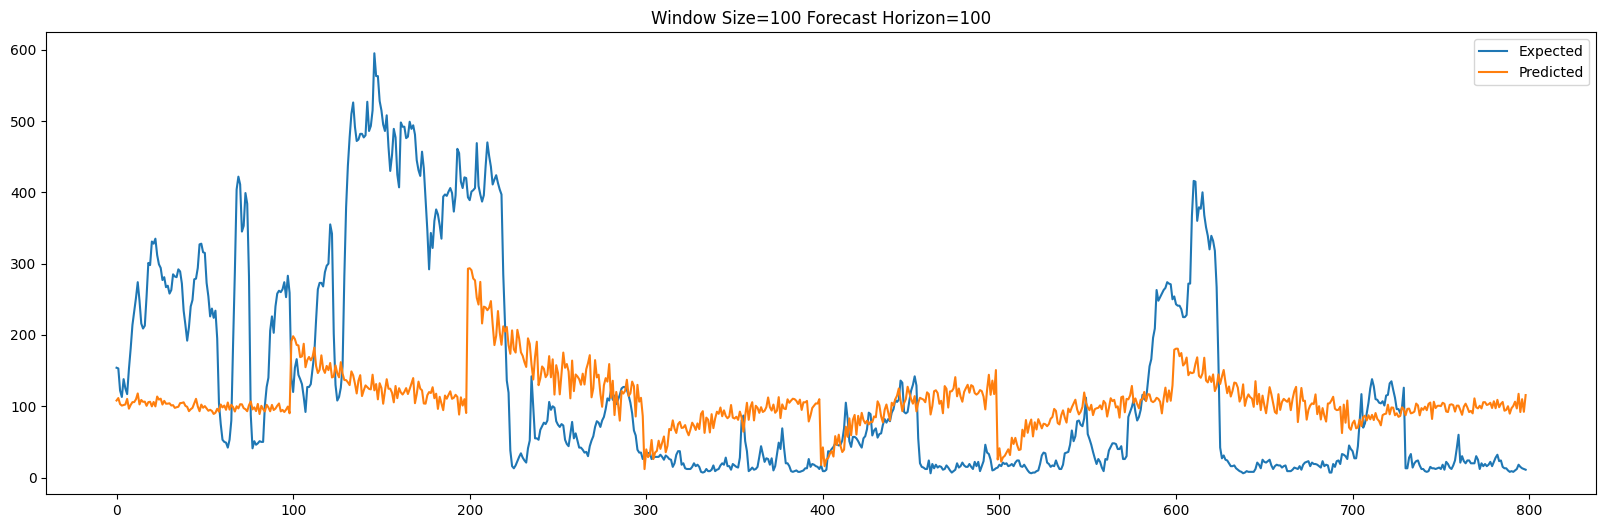

MSE=18578.102888501162


In [ ]:
lstmModule.evaluate(information["expected"], information["predicted"])

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    }
]


In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        lstmModule = LSTM_Module(params["Data"], params["WindowSize"], params["ForecastHorizon"])
        information = lstmModule.driver(params["TrainRatio"], params["ValRatio"], params["LstmUnits"], params["DenseUnits"], params["Epochs"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 2)             88        
                                                                 
 lstm_1 (LSTM)               (None, 2)                 40        
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (6

In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo2/LstmResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo2/LstmResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

12471.143957018774 64.39404010772705
----------------------------------------------------------------------------------------------------
10735.609918641056 141.57731924057006
----------------------------------------------------------------------------------------------------
65255.033489010515 260.27941355705264
----------------------------------------------------------------------------------------------------
13582.613208704966 66.1875479221344
----------------------------------------------------------------------------------------------------
13189.32550022675 194.86649866104125
----------------------------------------------------------------------------------------------------
11467.648816874247 302.8014082431793
----------------------------------------------------------------------------------------------------


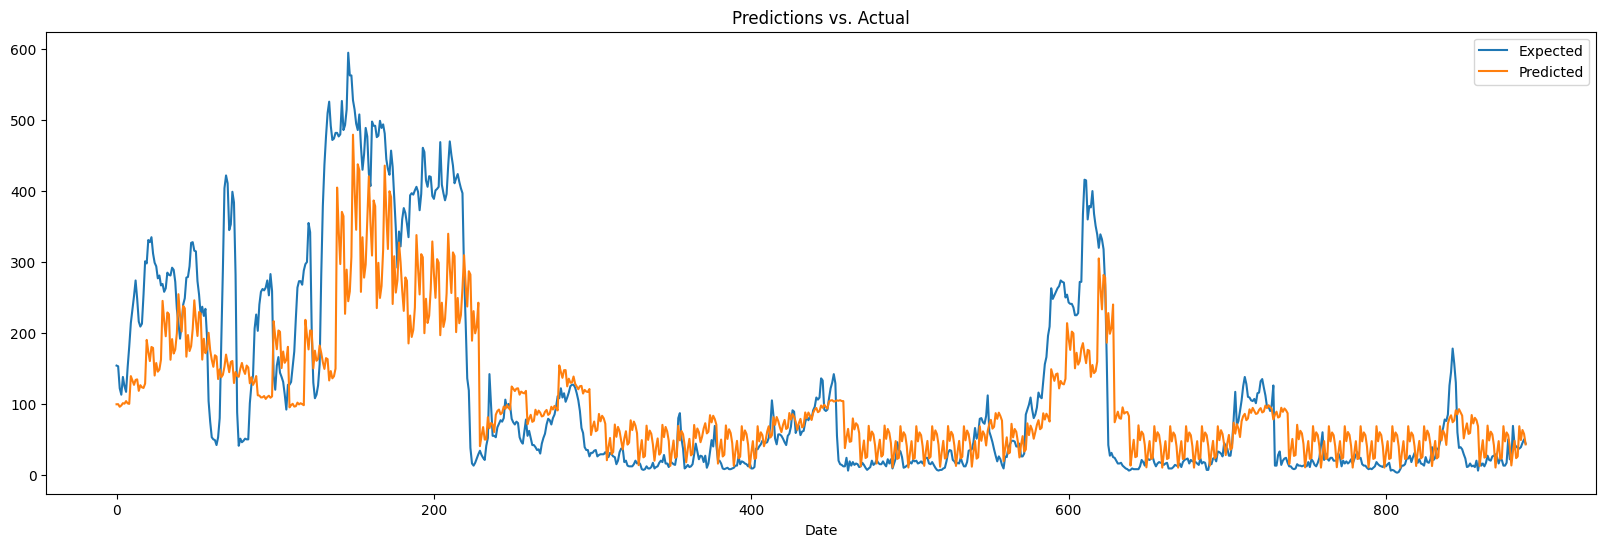

In [ ]:
plot_results(data[-1]["runs"][2]["expected"], data[-1]["runs"][2]["predicted"])

In [ ]:
data = df



scaler = MinMaxScaler()
scaler.fit(data)
train_scaled = scaler.transform(data)



X = train_scaled[:10000]
y = train_scaled[:, 0][:10000]

# X = X[:-ForecastHorizon]
# y = y[ForecastHorizon:]

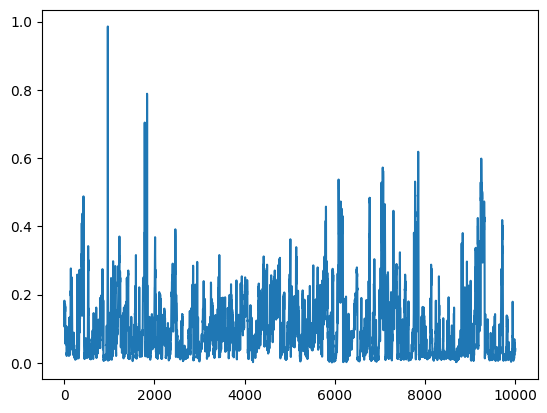

In [ ]:
plt.plot(y)

In [ ]:
def seriesToRollingWindowSeries(series, windowSize, univariate=False):
    data = []
    if not univariate:
        for i in range(len(series)-windowSize):      # Each window
            features = []
            # for featureNum in range(series.shape[-1]):        # Each feature
            features = series[i:i+windowSize, :]
            data.append(features)
    else:
        for i in range(len(series)-windowSize):      # Each window
            data.append(series[i:i+windowSize])
    return np.array(data)

In [ ]:
ForecastHorizon = 10
WindowSize = 10

X_rolling = seriesToRollingWindowSeries(X, WindowSize)
y_rolling = seriesToRollingWindowSeries(y, ForecastHorizon, univariate=True)
# print(X_rolling.shape, y_rolling.shape)
X_rolling = X_rolling[:-ForecastHorizon]
y_rolling = y_rolling[WindowSize:]
# print(X_rolling.shape, y_rolling.shape)
# y = y[WindowSize:]
trainRatio = 0.8
valRatio = 0.1
trainSplitIndex = int(len(X)*trainRatio)
valSplitIndex = int(len(X)*(trainRatio+valRatio))

X_train, y_train = X_rolling[:trainSplitIndex], y_rolling[:trainSplitIndex]
X_val, y_val = X_rolling[trainSplitIndex:valSplitIndex], y_rolling[trainSplitIndex:valSplitIndex]
X_test, y_test = X_rolling[valSplitIndex:], y_rolling[valSplitIndex:]

In [ ]:
X_train.shape, y_train.shape
X_val.shape, y_val.shape
X_test.shape, y_test.shape

((980, 10, 8), (980, 10))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
n_steps_out=1
tf.random.set_seed(42)

# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()


# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# # model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=64, input_shape=(WindowSize, X_train.shape[2])))
# # model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()

# model = keras.Sequential()
# model.add(keras.layers.LSTM(64, input_shape=(WindowSize, X_train.shape[2])))
# model.add(keras.layers.Dense(1))
# model.compile(loss="mae", optimizer="adam")


model = Sequential()
model.add(LSTM(units=8, return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
model.add(LSTM(units=8))
model.add(Dense(units=8))
model.add(Dropout(0.2))
model.add(Dense(units=8))
model.add(Dense(ForecastHorizon))
optimizer = AdamW(0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 8)             544       
                                                                 
 lstm_4 (LSTM)               (None, 8)                 544       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 10)                90        
                                                                 
Total params: 1322 (5.16 KB)
Trainable params: 1322 (5

In [ ]:
import numpy as np
from time import time

In [ ]:
t = time()
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))
print("Time taken:", time()-t)

Epoch 1/20
250/250 [==============================] - 7s 11ms/step - loss: 0.0178 - val_loss: 0.0038
Epoch 2/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0112 - val_loss: 0.0033
Epoch 3/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0032
Epoch 4/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 5/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0074 - val_loss: 0.0032
Epoch 6/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 7/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 8/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 9/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 10/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0054 - val_loss: 0.00

In [ ]:
def plot_results(actual, preds, image_path=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_actual = actual[1:]
    plot_preds = preds[1:]
    ax.plot(plot_actual, label='actual')
    ax.plot(plot_preds, label='preds')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

In [ ]:
y_test.shape, X_test.shape

((4174,), (4174, 2, 7))

In [ ]:
y_test_tmp.shape, testPredictions.shape

((980,), (980,))

31/31 [==============================] - 0s 4ms/step


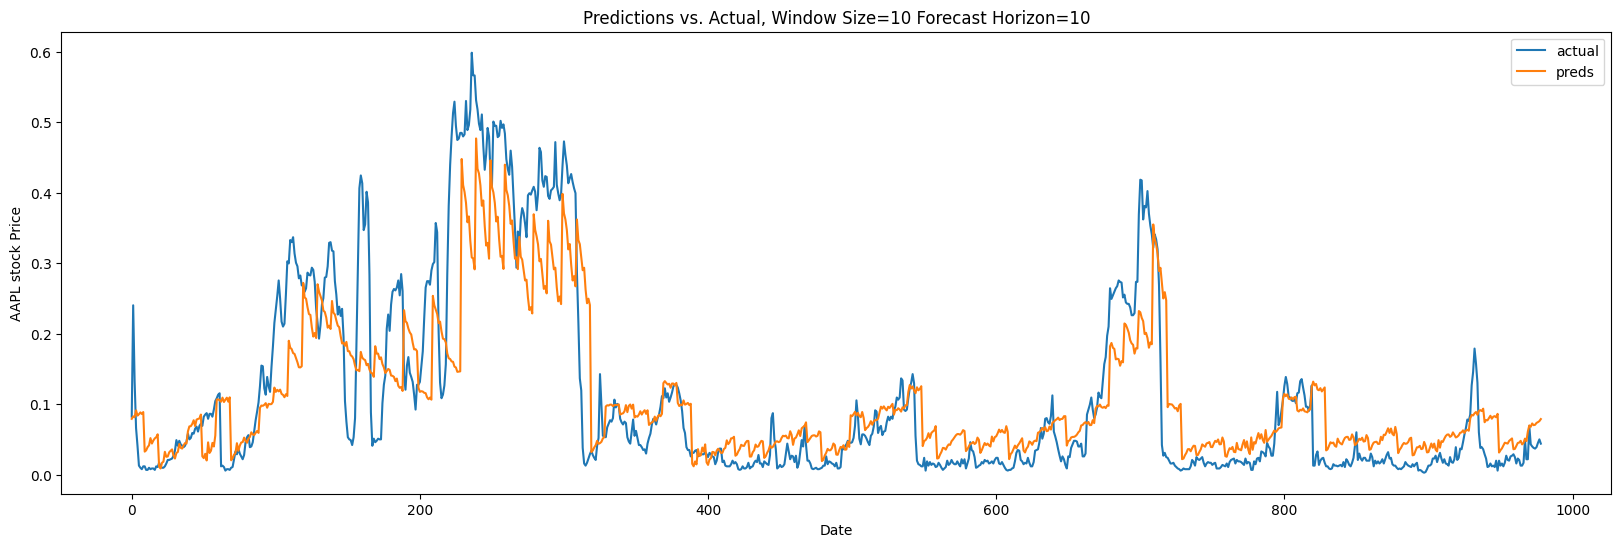

RMSE: 0.07656348830102438


In [ ]:
testPredictions = model.predict(X_test)
testPredictions = testPredictions[::ForecastHorizon]
testPredictions = testPredictions.reshape(testPredictions.shape[0]*testPredictions.shape[1])


y_test_tmp = y_test[::ForecastHorizon]
y_test_tmp = y_test_tmp.reshape(y_test_tmp.shape[0]*y_test_tmp.shape[1])

plot_results(y_test_tmp, testPredictions, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=WindowSize, ForecastHorizon=ForecastHorizon))
mse = ((y_test_tmp- testPredictions)**2).mean()
print("RMSE:", mse**0.5)

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:


    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                for featureNum in range(series.shape[-1]):        # Each feature
                    features.append(series[i:i+windowSize, featureNum])
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        # global self.TargetComplexShape
        self.TargetComplexShape = ComplexValuedArray.shape
        # print(TARGET_COMPLEX_SHAPE)
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, mask=True, maskPercentage=0):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if mask:
                    maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                    frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            # timeSeries.append(rollingWindowTimeSeries[i][-1])
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, univariate=False, trainRatio=0.6, valRatio=0.2, pca=True, pcaComponents=0):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))

        self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage)

        self.X, self.y = self.rollingWindowFrequencies[:-1], self.rollingWindowFrequencies[:, -1][1:]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if pca:
            covar_matrix = PCA(n_components = pcaComponents)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]


    def TrainSetup(self, hiddenLayers, hiddenUnits):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        self.model.summary()

    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
            ax.set_title(title_suffix)
        ax.set_xlabel('Date')
        # ax.set_ylabel(xlabel)
        ax.legend()
        plt.show()

    def driver(self, univariate=False, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, pca=True, pcaComponents=20):
        initialTime = time()
        self.DataPreprocessor(univariate, trainRatio, valRatio, pca=pca, pcaComponents=pcaComponents)
        self.TrainSetup(hiddenLayers, hiddenUnits)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val))
        totalTime = time() - initialTime

        testPredictions = self.model.predict(self.X_test)

        pred = self.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, self.TargetComplexShape)
        actual = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)

        pred = self.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=1)
        actual = self.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=1)


        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)
        # print("Predicted:", predicted.shape)
        predicted = predicted.reshape(predicted.shape[0], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)
        expected = self.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=self.ForecastHorizon)
        # print("Expected:", expected.shape)
        expected = expected.reshape(expected.shape[0], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:


    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                for featureNum in range(series.shape[-1]):        # Each feature
                    features.append(series[i:i+windowSize, featureNum])
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        # global self.TargetComplexShape
        self.TargetComplexShape = ComplexValuedArray.shape
        # print(TARGET_COMPLEX_SHAPE)
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        # frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
        frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, mask=True, maskPercentage=0):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if mask:
                    maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                    # frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            # timeSeries.append(rollingWindowTimeSeries[i][-1])
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, univariate=False, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))

        self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage)

        self.originalX, self.originalY = self.rollingWindowTimeSeries[:-1], self.rollingWindowTimeSeries[:, -1][1:]
        self.X, self.y = self.rollingWindowFrequencies[:-1], self.rollingWindowFrequencies[:, -1][1:]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)
            # # Plotting the cumulative explained variance
            # plt.plot(np.cumsum(pcaObj.explained_variance_ratio_))
            # plt.xlabel('Number of Components')
            # plt.ylabel('Cumulative Explained Variance')
            # plt.title('Explained Variance vs. Number of Components')
            # plt.show()

            # Determine the number of components for 90% variance
            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1
            # print(f'Number of components for 90% variance: {n_components}')

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]
        print(self.originalX_test.shape, self.originalY_test.shape, self.X_test.shape, self.y_test.shape)


    def TrainSetup(self, hiddenLayers, hiddenUnits):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        self.model.summary()

    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
            ax.set_title(title_suffix)
        ax.set_xlabel('Date')
        # ax.set_ylabel(xlabel)
        ax.legend()
        plt.show()

    def driver(self, univariate=False, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95):
        initialTime = time()
        self.DataPreprocessor(univariate, trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio)
        self.TrainSetup(hiddenLayers, hiddenUnits)
        # return
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=[earlyStop])#, verbose=0)
        totalTime = time() - initialTime

        testPredictions = self.model.predict(self.X_test)

        pred = self.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, self.TargetComplexShape)
        actual = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)

        pred = self.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=1)
        actual = self.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=1)


        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)
        # print("Predicted:", predicted.shape)
        predicted = predicted.reshape(predicted.shape[0], 1)
        predicted = yScaler.inverse_transform(predicted)

        # expected = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)
        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        # expected = self.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=self.ForecastHorizon)
        # # print("Expected:", expected.shape)
        expected = expected.reshape(expected.shape[0], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        # information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "mse": mse, "num_params": self.model.count_params()}
        return information

In [ ]:
Data = df.values[:10000]
WindowSize = 100
ForecastHorizon = 100
MaskPercentage = 0.0
TrainRatio = 0.8
ValRatio = 0.1
HiddenLayers = 10
HiddenUnits = 20
Epochs = 20
Pca = True
PcaComponents = 50

In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=True, pcaVarExpRatio=0.95)

(899, 8, 100) (899, 100) (899, 115) (899, 200)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 20)                2320      
                                                                 
 dense_44 (Dense)            (None, 20)                420       
                                                                 
 dense_45 (Dense)            (None, 20)                420       
                                                                 
 dense_46 (Dense)            (None, 20)                420       
                                                                 
 dense_47 (Dense)            (None, 20)                420       
                                                                 
 dense_48 (Dense)            (None, 20)                420       
                                                                 
 dense_

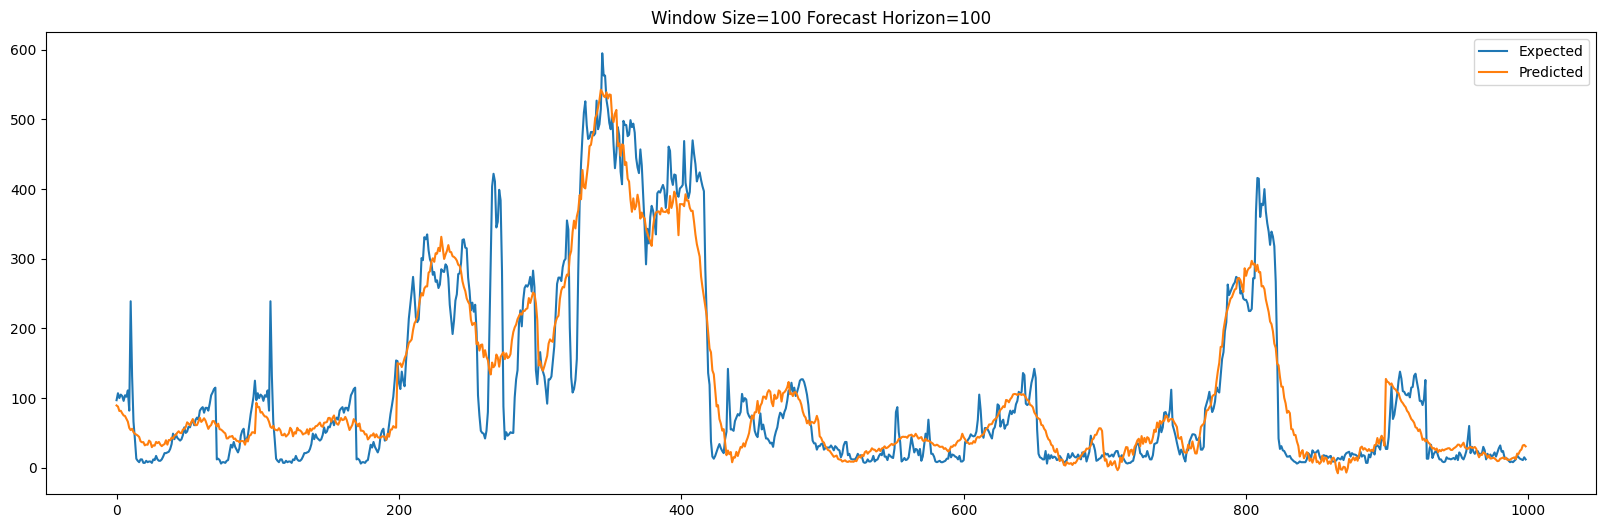

MSE=2397.3369090106366


In [ ]:
lstmModule.evaluate(information["expected"], information["predicted"])

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 20,
        "ForecastHorizon": 20,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    }
]

outputs = []

In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                        hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], pca=params["Pca"], pcaComponents=params["PcaComponents"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_182 (Dense)           (None, 2)                 102       
                                                                 
 dense_183 (Dense)           (None, 40)                120       
                                                                 
Total params: 222 (888.00 Byte)
Trainable params: 222 (888.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2174 - val_loss: 0.0614
Epoch 2/20
250/250 [==============================] - 1s 2ms/step - loss: 0.1603 - val_loss: 0.0407
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.0927 - val_loss: 0.0278
Epoch 4/20
250/250 [==============================] - 1s 2ms/step - loss: 0.0390 - val_loss: 0.0194
Epoch 5/20


In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo2/FourierResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo2/FourierResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

1298.1414482399157 23.37722840309143
----------------------------------------------------------------------------------------------------
4088.533488593039 24.627683448791505
----------------------------------------------------------------------------------------------------
7776.109987997508 26.676245641708373
----------------------------------------------------------------------------------------------------
1460.8792912092977 18.56649856567383
----------------------------------------------------------------------------------------------------
3469.3369070926406 22.68912787437439
----------------------------------------------------------------------------------------------------
5443.678102396583 25.965789222717284
----------------------------------------------------------------------------------------------------


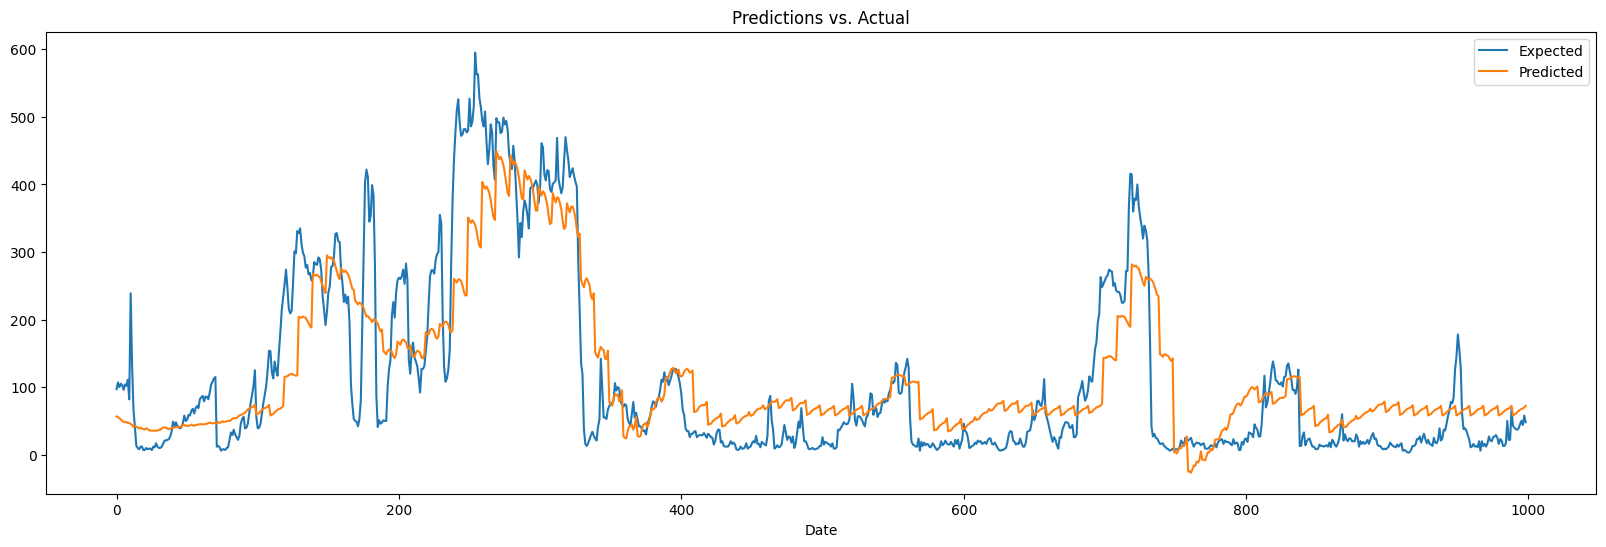

In [ ]:
plot_results(data[-1]["runs"][0]["expected"], data[-1]["runs"][0]["predicted"])

In [ ]:
def plot_results(actual, preds, image_path=None, title_suffix=None):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_actual = actual[1:]
    plot_preds = preds[1:]
    ax.plot(plot_actual, label='Expected')
    ax.plot(plot_preds, label='Predicted')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
        ax.set_title(title_suffix)
    ax.set_xlabel('Date')
    # ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

In [ ]:
data = df
data = data[[c for c in data if c not in ['pm2.5']] + ['pm2.5']]
scaler = MinMaxScaler()
scaler.fit(data)
train_scaled = scaler.transform(data)
train_scaled = train_scaled[:10000]

In [ ]:
WindowSize = 10
ForecastHorizon = 10
MaskPercentage = 0.00
# TimeSeries = dataset.values #train #.values
# TimeSeries = train.values #.values
TimeSeries = train_scaled
TARGET_COMPLEX_SHAPE = None
FrequenciesToConsider = int(WindowSize*(1-MaskPercentage))

univariate = False
trainRatio = 0.8
valRatio = 0.1
FREQUENCIES_MEASURED = None

In [ ]:
ft.y.shape
# plt.plot(ft.y_test)

(41747, 4)

In [ ]:
train_scaled.shape

(41757, 8)

In [ ]:
ft.rollingWindowTimeSeries.shape

(41747, 8, 10)

In [ ]:
ft.rollingWindowFrequencies.shape

(41747, 8, 4)

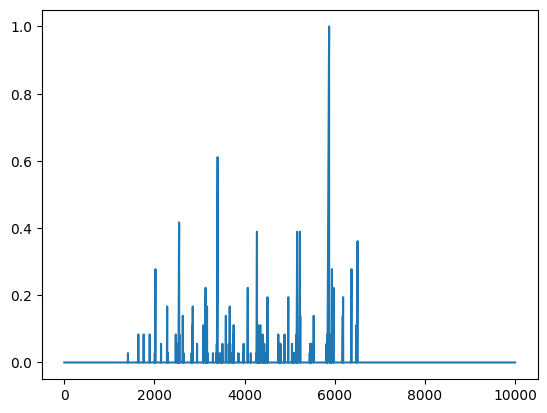

In [ ]:
plt.plot(train_scaled[:, -1])

In [ ]:
ft = FourierInformedTimeSeriesForecaster(TimeSeries, WindowSize, ForecastHorizon=10, MaskPercentage=0.0)
ft.DataPreprocessor(univariate, trainRatio, valRatio, pca=True, pcaComponents=20)
ft.TrainSetup(0, 3)
trainHistory = ft.model.fit(ft.X_train, ft.y_train, epochs=20, validation_data=(ft.X_val, ft.y_val))

8000
9000
(10000, 8)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 20)                420       
                                                                 
Total params: 420 (1.64 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 2s 5ms/step - loss: 0.7261 - val_loss: 0.4242
Epoch 2/20
250/250 [==============================] - 0s 2ms/step - loss: 0.1380 - val_loss: 0.0806
Epoch 3/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0207
Epoch 4/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 5/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 6/20
250/250 [===========

In [ ]:
pred.shape

(4180,)

31/31 [==============================] - 0s 6ms/step


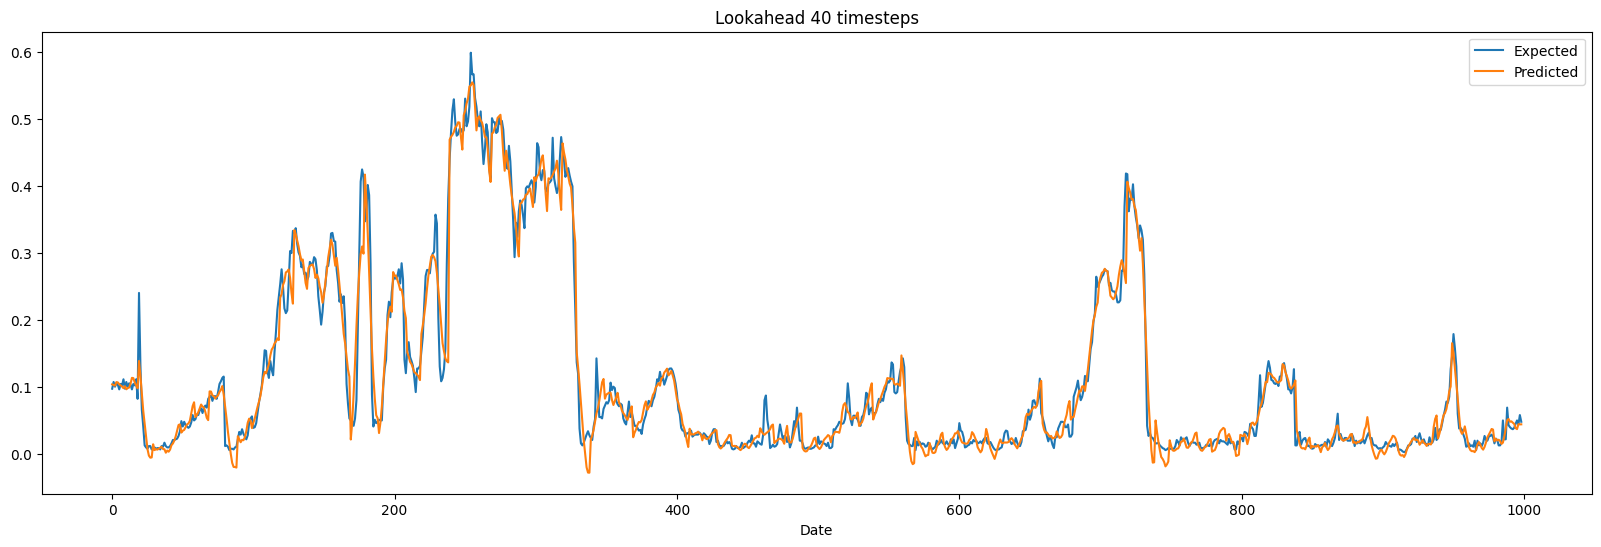

RMSE: 0.025067996711345446


In [ ]:
testPredictions = ft.model.predict(ft.X_test)
pred = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, ft.TargetComplexShape)
pred = ft.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=10)
actual = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(ft.y_test, ft.TargetComplexShape)
actual = ft.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=10)

ft.plot_results(actual, pred, title_suffix='Lookahead 40 timesteps')
mse = ((actual- pred)**2).mean()
print("RMSE:", mse**0.5)

In [ ]:
def seriesToRollingWindowSeries(series, windowSize, univariate=False):
    data = []
    if not univariate:
        for i in range(len(series)-windowSize):      # Each window
            features = []
            # for featureNum in range(series.shape[-1]):        # Each feature
            features = series[i:i+windowSize, :]
            data.append(features)
    else:
        for i in range(len(series)-windowSize):      # Each window
            data.append(series[i:i+windowSize])
    return np.array(data)


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame, concat

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
look_back = 2
predict_forward = 10

In [ ]:
sdf = series_to_supervised(
    standardization(
        label_fit_transform(df, "cbwd")), look_back, predict_forward).drop(
        [
         "DEWP(t)", "TEMP(t)", "PRES(t)", "cbwd(t)", "Iws(t)", "Is(t)", "Ir(t)"
         ], axis=1, inplace=False).astype('float32')

In [ ]:
sdf.head()

,pm2.5(t-2),DEWP(t-2),TEMP(t-2),PRES(t-2),cbwd(t-2),Iws(t-2),Is(t-2),Ir(t-2),pm2.5(t-1),DEWP(t-1),...,Is(t+8),Ir(t+8),pm2.5(t+9),DEWP(t+9),TEMP(t+9),PRES(t+9),cbwd(t+9),Iws(t+9),Is(t+9),Ir(t+9)
26,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893,0.367647,...,0.037037,0.0,0.152918,0.470588,0.229508,0.636364,0.666667,0.035590,0.0,0.0
27,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960,0.426471,...,0.000000,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.041130,0.0,0.0
28,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093,0.485294,...,0.000000,0.0,0.164990,0.470588,0.229508,0.618182,0.666667,0.048244,0.0,0.0
29,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833,0.485294,...,0.000000,0.0,0.158954,0.455882,0.229508,0.618182,0.666667,0.055359,0.0,0.0
30,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658,0.485294,...,0.000000,0.0,0.154930,0.455882,0.229508,0.618182,0.666667,0.062473,0.0,0.0


In [ ]:
total = sdf.shape[0]
split_point = [total * 60 // 100, total * 80 // 100]

In [ ]:
def transform(values):
    return values.reshape(values.shape[0], 1, values.shape[1])

In [ ]:
train_data = sdf[:split_point[0]].values

valid_data = sdf[split_point[0]: split_point[1]].values

test_data = sdf[split_point[1]: ].values

In [ ]:
print("train_data.shape = {}, valid_data.shape = {}, test_data.shape = {}".format(
    train_data.shape, valid_data.shape, test_data.shape))

train_data.shape = (25047, 89), valid_data.shape = (8349, 89), test_data.shape = (8350, 89)


In [ ]:
train_x, train_y = transform(train_data[:, : -1]), train_data[:, -1]

valid_x, valid_y = transform(valid_data[:, : -1]), valid_data[:, -1]

test_x, test_y = transform(test_data[:, : -1]), test_data[:, -1]

In [ ]:
print("train_x.shape = {}, train_y = {}".format(train_x.shape, train_y.shape))
print("valid_x.shape = {}, valid_y = {}".format(valid_x.shape, valid_y.shape))
print("test_x.shape = {}, test_y = {}".format(test_x.shape, test_y.shape))

train_x.shape = (25047, 1, 88), train_y = (25047,)
valid_x.shape = (8349, 1, 88), valid_y = (8349,)
test_x.shape = (8350, 1, 88), test_y = (8350,)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(1, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(keras.layers.Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1)                 360       
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_x,
                    train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    shuffle=False)

Epoch 1/10
783/783 [==============================] - 6s 4ms/step - loss: 0.0148 - val_loss: 0.0054
Epoch 2/10
783/783 [==============================] - 4s 5ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 3/10
783/783 [==============================] - 3s 3ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 4/10
783/783 [==============================] - 3s 3ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 5/10
783/783 [==============================] - 3s 4ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 6/10
783/783 [==============================] - 4s 5ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 7/10
783/783 [==============================] - 3s 4ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 8/10
783/783 [==============================] - 3s 4ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 9/10
783/783 [==============================] - 3s 3ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 10/10
783/783 [==============================] - 4s 5ms/step - loss: 0.0063 - val_loss: 0.0048

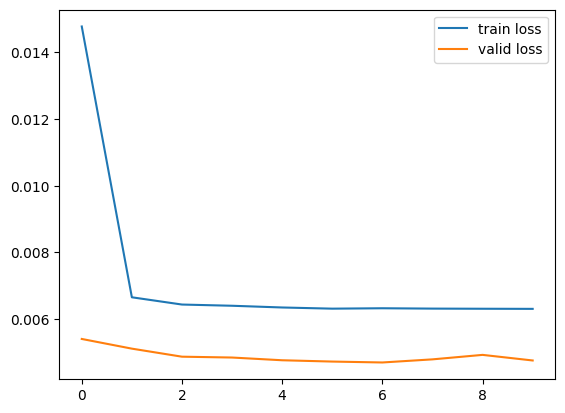

In [ ]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_x, test_y, verbose=0)

0.003900051349774003

In [ ]:
prediction = model.predict(test_x)
max_value = np.max(df["pm2.5"])
min_value = np.min(df["pm2.5"])
prediction = prediction[:, 0] * (max_value - min_value) + min_value
expectation = df["pm2.5"][split_point[1] + look_back: ].values

261/261 [==============================] - 1s 2ms/step


In [ ]:
print("prediction's shape = {}, expectation's shape = {}".format(prediction.shape, expectation.shape))

prediction's shape = (8350,), expectation's shape = (8359,)


In [ ]:
print(r2_score(expectation, prediction, multioutput="raw_values"))


ValueError: Found input variables with inconsistent numbers of samples: [8359, 8350]

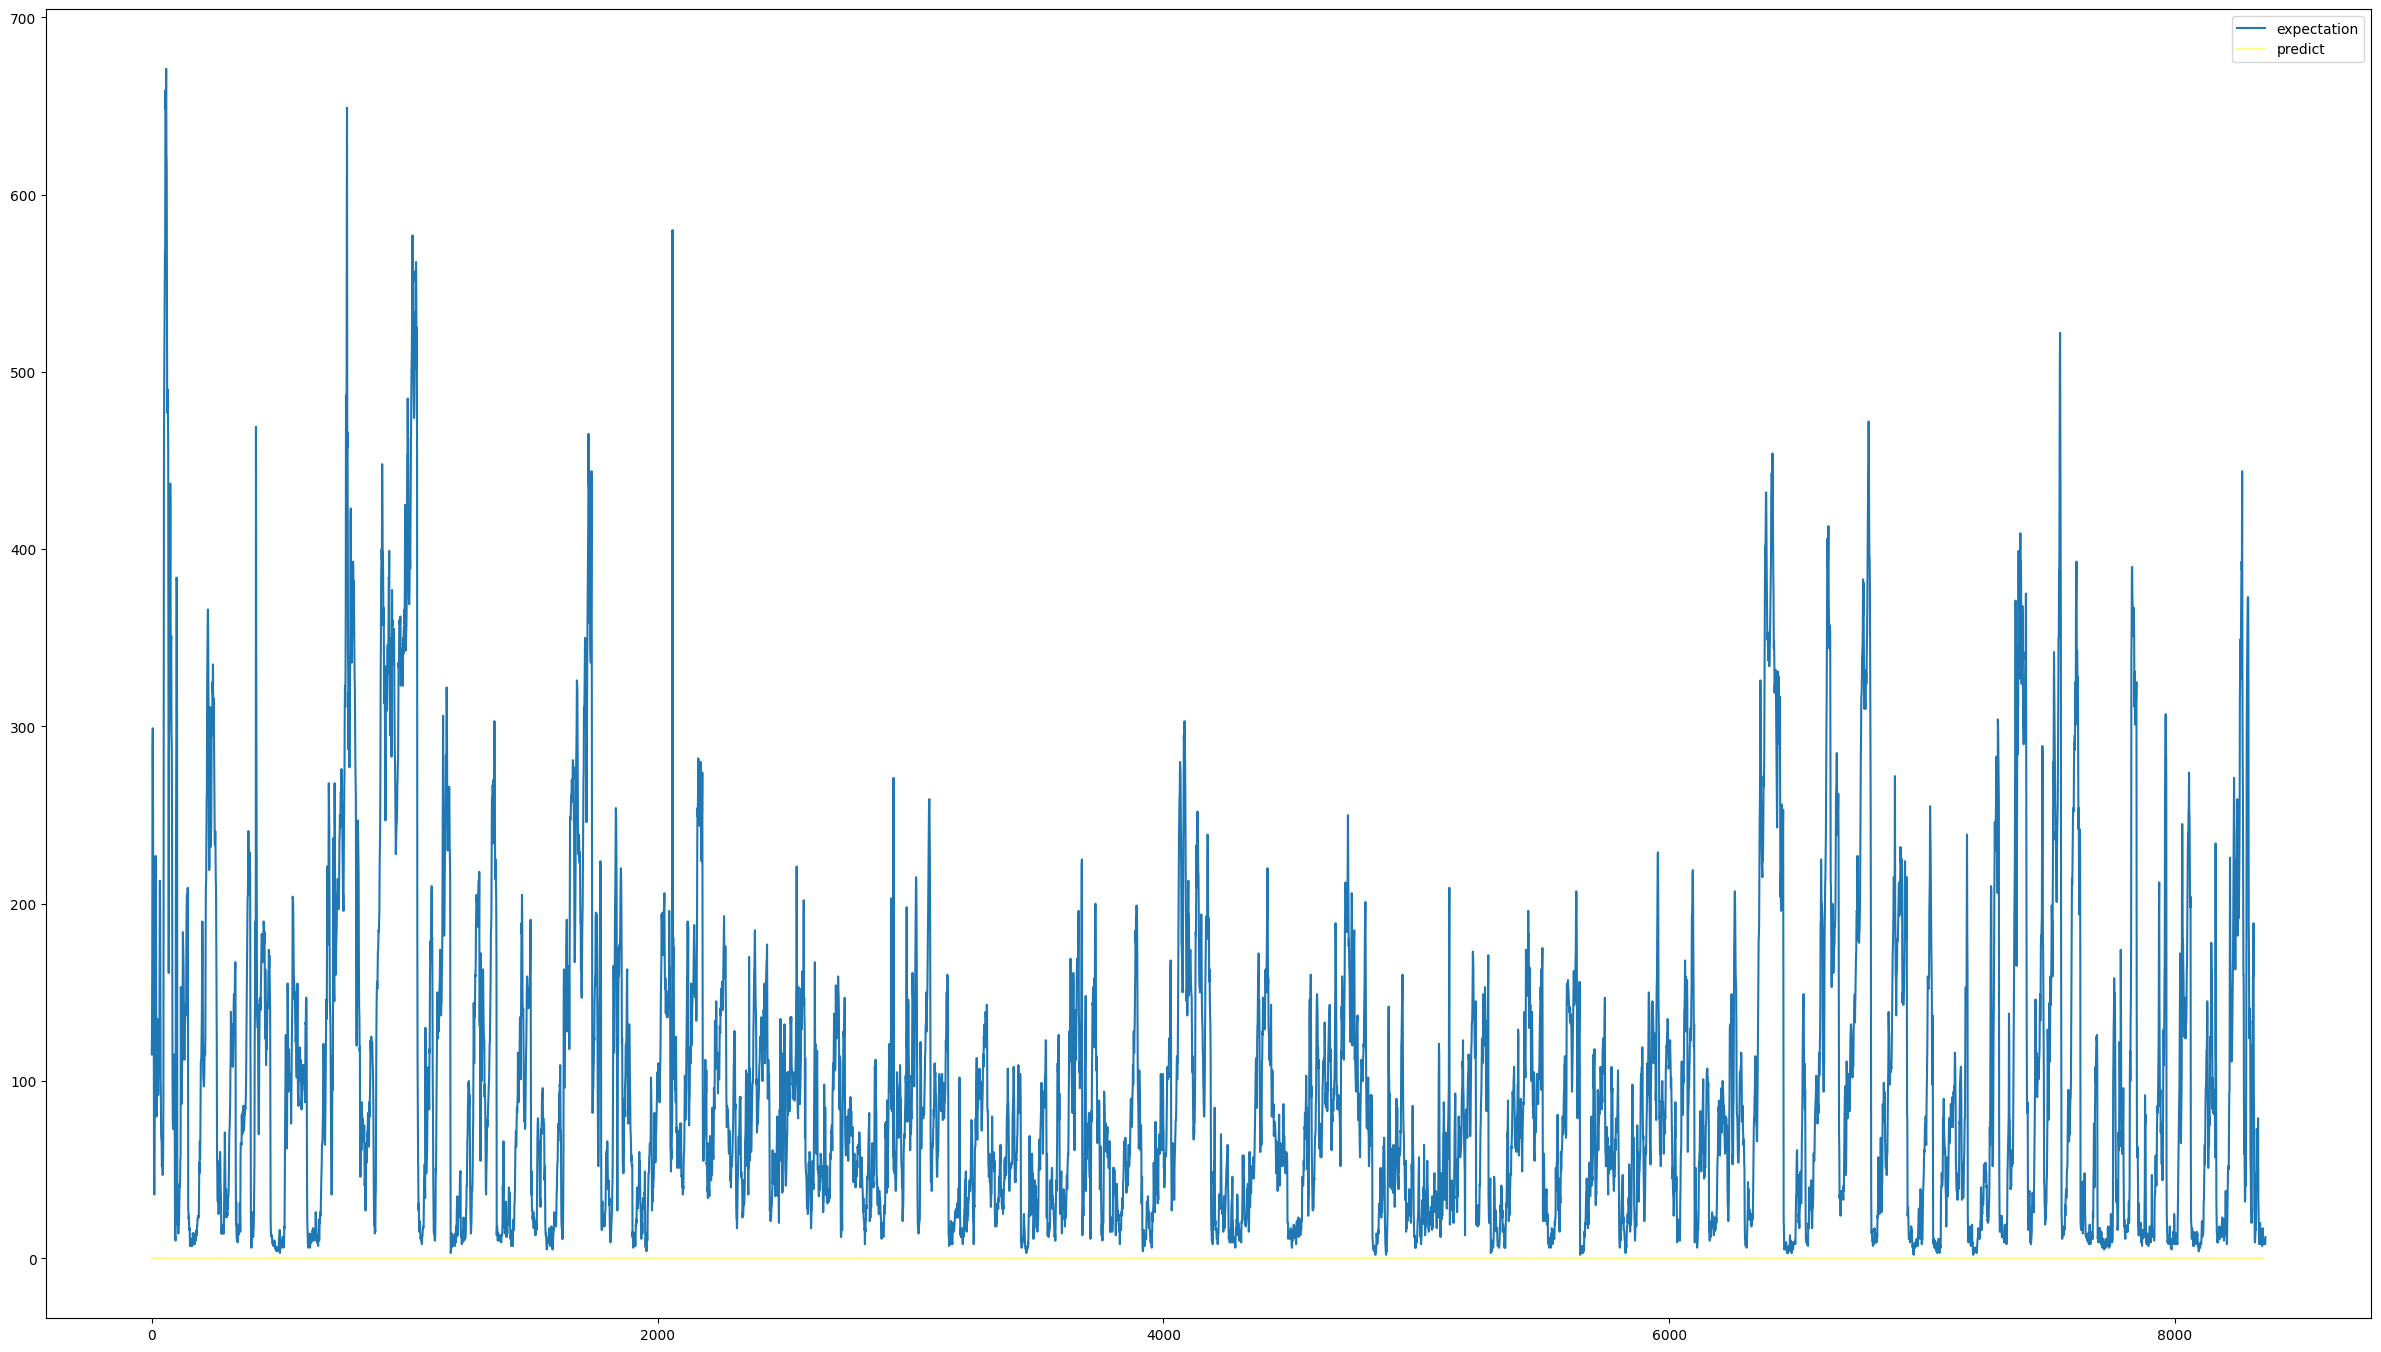

In [ ]:
plt.figure(figsize=(30, 17))
plt.plot(expectation, label="expectation")
plt.plot(prediction, label="predict", color="yellow", alpha=0.5)
plt.legend()
plt.show()